# Predizione dei prezzi dei consumi elettrici


**Magnani Alessandro**, num. matricola: 0000889833\
`alessandro.magnani18@studio.unibo.it`

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena


Citazioni:
* household-monthly-electricity-bill:\
https://www.kaggle.com/gireeshs/household-monthly-electricity-bill

## Descrizione del Problema e analisi Esplorativa
L'idea alla base di questo Dataset è osservare come il numero di persone e le dimensioni della casa influenzino il consumo mensile di elettricità in casa.

In questo progetto, infatti, si vuole realizzare un modello in grado di predire i prezzi dei consumi elettrici in base a parametri specifici come dimensioni e zona nella quale sono situate le varie abitazioni.

### Caricamento delle librerie

Iniziamo importando le librerie esterne che saranno utili per lo svolgimento del progetto:
- numpy, necessaria per eseguire operazioni su vettori e matrici N-dimensionali
- pandas, per il caricamento e la gestione dei dati tabellare
- matplotlib, necessaria alla creazione di diverse tipologie di grafici
- seaborn, che fornisce un'interfaccia di alto livello per disegnare grafici statistici interessanti e informativi.

Dopodichè abilitiamo l'inserimento dei grafici direttamente nel notebook con *%matplotlib inline*.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from math import sqrt

%matplotlib inline

### Caricamento del Dataset
Si recupera dalla Reposition GitHub il file del dataset.

In [2]:
import os.path
if not os.path.exists("prezzo.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://raw.githubusercontent.com/alessandromagnani17/data-intensive/main/prezzo.csv", "prezzo.csv")

Usiamo pandas per caricare i dati in un DataFrame dato l'URL del file.

In [3]:
dataset = pd.read_csv("prezzo.csv", sep=",")

In [4]:
dataset.insert(0, 'id', range(len(dataset)))
dataset.set_index("id", inplace=True)

Visualizziamo una parte (le prime 5 righe) del nostro dataset.

In [5]:
dataset.head()

,num_rooms,num_people,housearea,is_ac,is_tv,is_flat,ave_monthly_income,num_children,is_urban,amount_paid
id,,,,,,,,,,
0,3,3,742.57,1,1,1,9675.93,2,0,560.481447
1,1,5,952.99,0,1,0,35064.79,1,1,633.283679
2,3,1,761.44,1,1,1,22292.44,0,0,511.879157
3,0,5,861.32,1,1,0,12139.08,0,0,332.992035
4,1,8,731.61,0,1,0,17230.10,2,1,658.285625


### Preprocessing del dataset

Iniziamo cambiando nome alle colonne per una migliore comprensione del Dataset.

In [6]:
dataset.columns = "NumStanze NumPersone DimensioniCasa AriaCondizionata Tv Appartamento Reddito NumBambini AreaUrbana ImportoPagato".split()
dataset

,NumStanze,NumPersone,DimensioniCasa,AriaCondizionata,Tv,Appartamento,Reddito,NumBambini,AreaUrbana,ImportoPagato
id,,,,,,,,,,
0,3,3,742.57,1,1,1,9675.93,2,0,560.481447
1,1,5,952.99,0,1,0,35064.79,1,1,633.283679
2,3,1,761.44,1,1,1,22292.44,0,0,511.879157
3,0,5,861.32,1,1,0,12139.08,0,0,332.992035
4,1,8,731.61,0,1,0,17230.10,2,1,658.285625
...,...,...,...,...,...,...,...,...,...,...
995,3,0,991.31,0,1,0,12687.26,1,1,655.870111
996,2,5,847.97,0,1,0,39502.92,0,0,354.472693
997,2,4,660.94,1,0,0,10145.17,0,1,568.660550


Prima di analizzare il Dataset, occorre controllare che non vi siano valori NaN dal momento che potrebbero poi influire sulle operazioni successive di predizione, restituendoci valori imprecisi. 

In [7]:
dataset.isna().sum()

NumStanze           0
NumPersone          0
DimensioniCasa      0
AriaCondizionata    0
Tv                  0
Appartamento        0
Reddito             0
NumBambini          0
AreaUrbana          0
ImportoPagato       0
dtype: int64

Dal momento che non ci sono valori NaN, non occorre eliminarli e possiamo passare all'analisi della struttura del Dataset.

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   NumStanze         1000 non-null   int64  
 1   NumPersone        1000 non-null   int64  
 2   DimensioniCasa    1000 non-null   float64
 3   AriaCondizionata  1000 non-null   int64  
 4   Tv                1000 non-null   int64  
 5   Appartamento      1000 non-null   int64  
 6   Reddito           1000 non-null   float64
 7   NumBambini        1000 non-null   int64  
 8   AreaUrbana        1000 non-null   int64  
 9   ImportoPagato     1000 non-null   float64
dtypes: float64(3), int64(7)
memory usage: 85.9 KB


### Comprensione delle feature

Le colonne del nostro Dataset hanno i seguenti significati:
- **`NumStanze`**: Numero di stanze della abitazione
- **`NumPersone`**: Numero di persone nella abitazione
- **`DimensioniCasa`**: Dimensioni della abitazione in metri cubi
- **`AriaCondizionata`**: Indica se è presente o meno l'aria condizionata all'interno dell'abitazione (assume valore 0 quando è assente e 1 quando è presente)
- **`Tv`**: Indica se è presente o meno un televisore all'interno dell'abitazione (assume valore 0 quando è assente e 1 quando è presente)
- **`Appartamento`**: Indica se l'abitazione è o meno un appartamento (assume valore 0 quando non lo è e 1 quando lo è)
- **`Reddito`**: Reddito medio mensile del nucleo familiare (in Euro)
- **`NumBambini`**: Numero di bambini in casa
- **`AreaUrbana`**: Indica se l'abitazione è situata in una zona urbana (assume valore 0 quando non lo è e 1 quando lo è)


Variabile da predire:
- **`ImportoPagato`**: Importo pagato come bolletta mensile

## Esplorazione delle singole feature

Per l'esplorazione delle singole feature, iniziamo osservando le informazioni dei vari parametri sfruttando la funzione `describe`.


In [9]:
dataset.describe()

,NumStanze,NumPersone,DimensioniCasa,AriaCondizionata,Tv,Appartamento,Reddito,NumBambini,AreaUrbana,ImportoPagato
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.962000,4.897000,794.703420,0.376000,0.798000,0.477000,24684.986550,1.078000,0.608000,600.396359
std,1.030348,2.007591,147.771736,0.484622,0.401693,0.499721,9678.228224,0.934232,0.488441,181.406210
min,-1.000000,-1.000000,244.400000,0.000000,0.000000,0.000000,-1576.440000,0.000000,0.000000,87.851850
25%,1.000000,4.000000,691.037500,0.000000,1.000000,0.000000,18036.762500,0.000000,0.000000,475.065141
50%,2.000000,5.000000,789.970000,0.000000,1.000000,0.000000,24742.575000,1.000000,1.000000,598.331726
75%,3.000000,6.000000,892.955000,1.000000,1.000000,1.000000,31402.357500,2.000000,1.000000,729.930489
max,5.000000,11.000000,1189.120000,1.000000,1.000000,1.000000,56531.080000,4.000000,1.000000,1102.994109


Notiamo dalla riga indicante i valori minimi come NumStanze, NumPersone e Reddito abbiano valori negativi (nel caso di NumStanze e NumPersone ad esempio, assumono valore -1 quando i dati sono mancanti).
Poichè non è possibile ricostruire valori mancanti e i valori negativi sono concettualmente un ostacolo alla nostra predizione, siamo costretti ad eliminare tutte le righe che li contengono.

In [10]:
for column in dataset:
    dataset = dataset[dataset[column] >= 0]

In [11]:
dataset.describe()

,NumStanze,NumPersone,DimensioniCasa,AriaCondizionata,Tv,Appartamento,Reddito,NumBambini,AreaUrbana,ImportoPagato
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000
mean,1.974619,4.916751,794.795076,0.376650,0.796954,0.475127,24864.951096,1.073096,0.608122,600.532678
std,1.011301,1.978331,148.095265,0.484792,0.402471,0.499635,9512.214266,0.928729,0.488418,181.323729
min,0.000000,0.000000,244.400000,0.000000,0.000000,0.000000,37.780000,0.000000,0.000000,87.851850
25%,1.000000,4.000000,691.100000,0.000000,1.000000,0.000000,18394.700000,0.000000,0.000000,475.077740
50%,2.000000,5.000000,788.730000,0.000000,1.000000,0.000000,24822.960000,1.000000,1.000000,598.522001
75%,3.000000,6.000000,893.340000,1.000000,1.000000,1.000000,31462.810000,2.000000,1.000000,729.877149
max,5.000000,11.000000,1189.120000,1.000000,1.000000,1.000000,56531.080000,4.000000,1.000000,1102.994109


A seguito di questa operazione, abbiamo a disposizione 985 righe differenti, un numero comunque sufficientemente alto per le operazioni successive.

### Analisi Esplorativa delle Feature

Procediamo ora con l'analisi delle singole feature a partire con la variabile da predire.

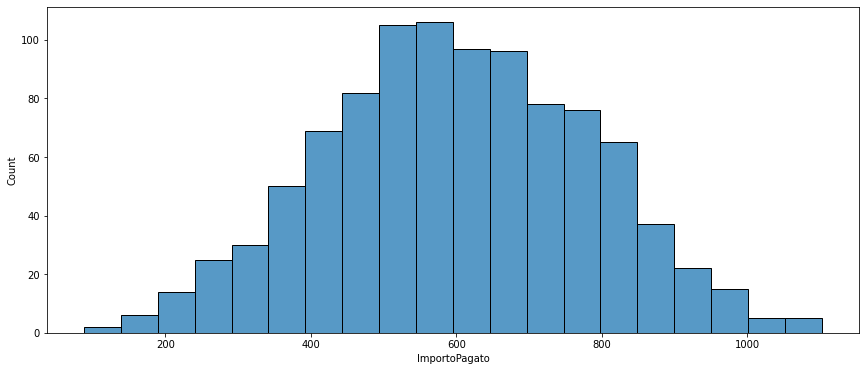

In [12]:
plt.figure(figsize=(32,6))

plt.subplot(1,2,1)
sb.histplot(x="ImportoPagato", data=dataset);

Da questo istogramma è facilmente intuibile come l'importo pagato mensilmente (fondamentalmente la bolletta elettrica) è molto concentrato nell'intervallo che va dai 400 agli 800 euro.

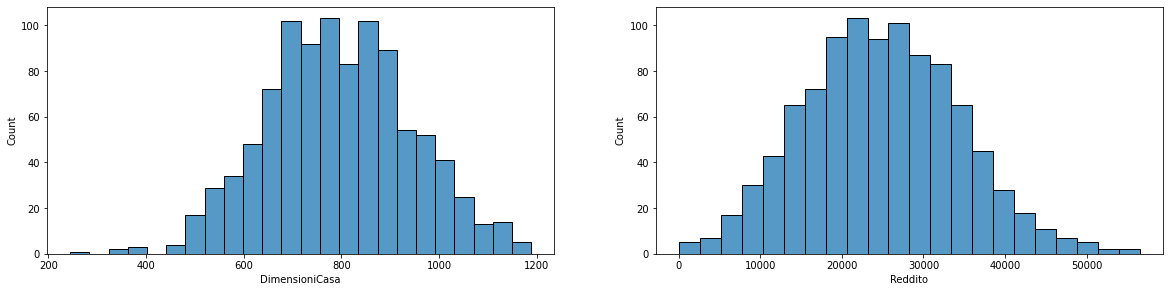

In [13]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
sb.histplot(x="DimensioniCasa", data=dataset);

plt.subplot(2,2,2)
sb.histplot(x="Reddito", data=dataset);

Dai grafici sopra disegnati si può invece notare come la maggior parte delle abitazioni sono dai 600 ai 1000 metri cubi di dimensione, costituendo una simil curva gaussiana.

Stesso discorso si può estendere alla feature riguardante il Reddito che vede valori frequenti tra i 15.000 e i 35.000 euro.

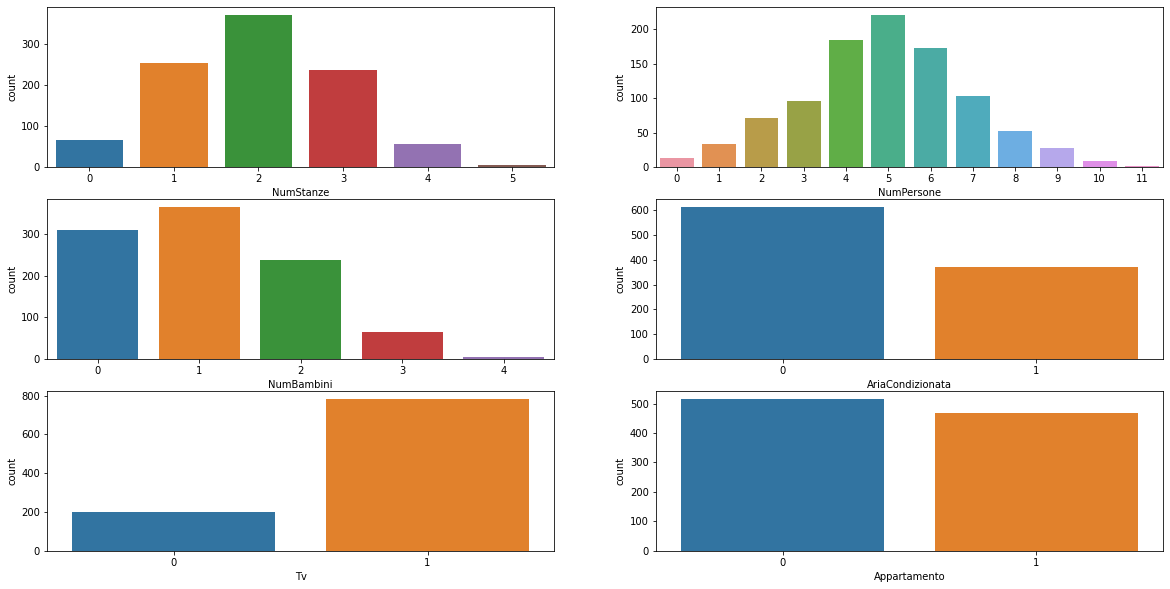

In [14]:
plt.figure(figsize=(20,10))

plt.subplot(3,2,1)
sb.countplot(x="NumStanze", data=dataset);

plt.subplot(3,2,2)
sb.countplot(x="NumPersone", data=dataset);

plt.subplot(3,2,3)
sb.countplot(x="NumBambini", data=dataset);

plt.subplot(3,2,4)
sb.countplot(x="AriaCondizionata", data=dataset);

plt.subplot(3,2,5)
sb.countplot(x="Tv", data=dataset);

plt.subplot(3,2,6)
sb.countplot(x="Appartamento", data=dataset);

Da questi istogrammi si può osservare come:
- Il numero di stanze di una abitazione costituisce una curva gaussiana che ha come moda il valore 2
- Il numero di persone che vivono all'interno di un'abitazione solitamente varia dalle 4 alle 6
- La maggior parte delle famiglie facenti parte il Dataset o non ha figli o ne ha solamente uno
- Vi sono più abitazioni non aventi Aria Condizionata 
- Quasi tutte le case hanno una Tv
- Più o meno la metà delle famiglie abita in un appartamento


### Esplorazione delle relazioni tra Feature

Significativa può essere la distinzione tra le abitazioni che si trovano in un'area urbana da quelle che si trovano in periferia.
Visualizziamo prima come sono distribuiti i valori tra case in area urbana e case in periferia.

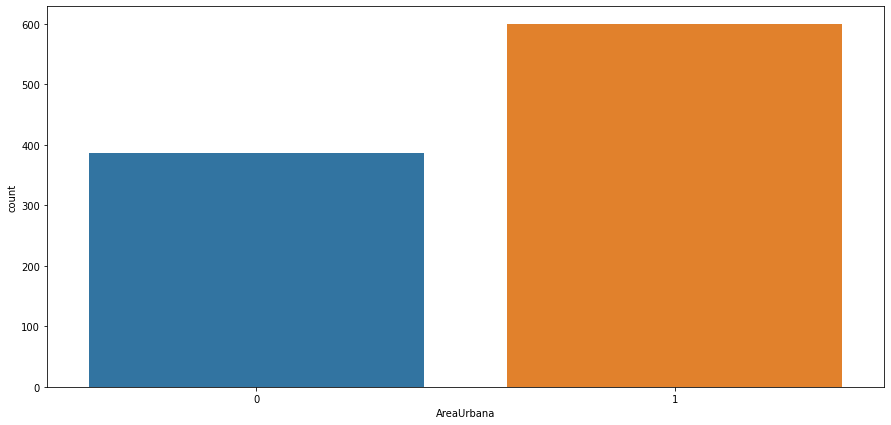

In [15]:
plt.figure(figsize=(15,7))

plt.subplot(1,1,1)
sb.countplot(x="AreaUrbana", data=dataset);

Notiamo subito come i valori siano un po' sbilanciati ma comunque significativi per una comparazione.

Suddividiamo, quindi, il Dataset in due viste (una per le abitazioni in zone urbane e una per quelle in periferia).

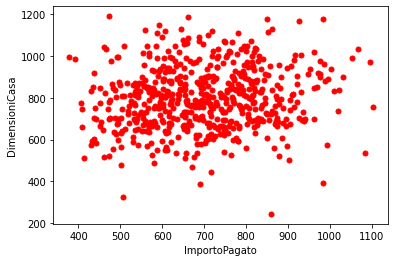

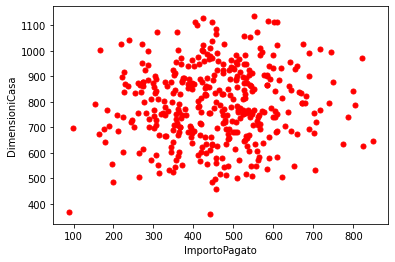

In [16]:
dati_urbana = dataset[dataset["AreaUrbana"] == 1]
dati_periferia = dataset[dataset["AreaUrbana"] == 0]

dati_urbana.plot.scatter("ImportoPagato", "DimensioniCasa", s=25, c="red");
dati_periferia.plot.scatter("ImportoPagato", "DimensioniCasa", s=25, c="red");

Come si può vedere con l'esempio sopra, i valori sono molto distribuiti su tutto il grafico con, però, differenze importanti tra un grafico e l'altro. Il primo, che considera solo le abitazioni in aree urbane, vede le dimensioni delle case e gli importi più elevati rispetto alle zone periferiche.
Si può osservare ancora meglio con la seguente visualizzazione dei dati.

In [17]:
dati = dataset.groupby(["AreaUrbana"])
dati.mean()

,NumStanze,NumPersone,DimensioniCasa,AriaCondizionata,Tv,Appartamento,Reddito,NumBambini,ImportoPagato
AreaUrbana,,,,,,,,,
0,1.997409,4.963731,789.580130,0.406736,0.782383,0.476684,25453.254275,1.080311,454.055595
1,1.959933,4.886477,798.155626,0.357262,0.806344,0.474124,24485.844207,1.068447,694.923586


Vi sono alcune considerazioni che possiamo trarre dalla suddivisione appena effettuata:
- L'importo pagato è nettamente più alto in centro dove la media si attesta sui 700 euro contro i 450 della periferia
- Altro dato interessante e inaspettato allo stesso tempo è quello riferito alle dimensioni delle case, superiori in centro nonostante gli spazi siano limitati
- I restanti dati sono molto simili, sinonimo del fatto che la posizione della casa non influisce direttamente sulle altre feature.

E' possibile fare considerazioni anche sui dati riguardanti la Tv e l'aria condizionata

In [18]:
dati = dataset.groupby(["AriaCondizionata", "Tv"])
dati.mean()

NumStanze  NumPersone  DimensioniCasa  Appartamento  \
AriaCondizionata Tv                                                        
0                0    1.944444    4.761905      755.326905      0.484127   
                 1    1.963115    4.897541      800.178361      0.469262   
1                0    2.067568    4.986486      789.088514      0.540541   
                 1    1.983165    4.996633      804.115724      0.464646   

                          Reddito  NumBambini  AreaUrbana  ImportoPagato  
AriaCondizionata Tv                                                       
0                0   23949.263492    1.015873    0.587302     467.026796  
                 1   25220.387398    1.114754    0.637295     565.595946  
1                0   25669.227162    1.054054    0.567568     634.074736  
                 1   24469.016061    1.033670    0.579125     706.218719

Da questa tabella si può osservare come la presenza di fattori come l'Aria Condizionata o la Tv, implichino un aumento nei costi della bolletta a fine mese, sintomo di un consumo di elettricità maggiore. Interessante notare come influisca di più e di conseguenza pesi di più nelle spese, l'uso dell'Aria condizionata rispetto a quello della Tv (infatti nelle case dove c'è solo la Tv, la spesa media si attesta sui 565 euro a discapito di chi ha solo l'aria condizionata dove l'importo raggiunge quota 630)


Nonostante questo risultato possa far pensare ad un uso maggiore dell'aria condizionata nelle zone dove si hanno costi maggiori (nelle aree urbane), questo non viene confermato nella tabella precedente che mostrava come fosse più comune avere l'aria condizionata in periferia. 

Il dato riguardante le Tv, invece, trova congruenze con quanto visto in precedenza, dato dal fatto che sia più comune possedere una Tv in città (dove si hanno costi più elevati).

,NumStanze,NumPersone,DimensioniCasa,AriaCondizionata,Tv,Appartamento,Reddito,AreaUrbana,ImportoPagato
NumBambini,,,,,,,,,
0,2.067524,4.877814,790.155177,0.395498,0.794212,0.508039,24256.213923,0.607717,506.598413
1,1.928962,5.051913,792.342623,0.385246,0.781421,0.461749,25227.412650,0.609290,594.189705
2,1.932773,4.735294,802.428403,0.336134,0.815126,0.445378,25268.158151,0.617647,681.610215
3,1.923077,4.953846,803.180923,0.369231,0.846154,0.461538,24713.607538,0.569231,765.567921
4,2.200000,5.600000,790.554000,0.600000,0.600000,1.000000,18971.028000,0.600000,902.800591


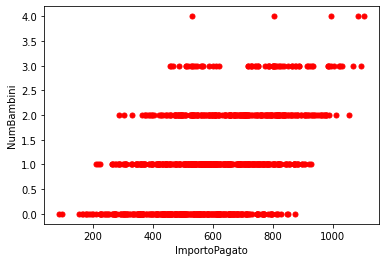

In [19]:
dati = dataset.groupby(["NumBambini"])
dataset.plot.scatter("ImportoPagato", "NumBambini", s=25, c="red");
dati.mean()

Rilevante anche la presenza di bambini nelle varie abitazioni, dato che comporta aumenti nelle dimensioni della casa e nell'importo da pagare a fine mese.

Procediamo preparando il training ed il validation set.

### Divisione tra Training e Validation set
Dividiamo le istanze del Dataset in due set:
- un training set che ci servirà per addestrare i vari modelli di regressione
- un validation set che ci servirà per verificare l'accuratezza dei modelli di regressione

Per fare ciò, usiamo la funzione train_test_split di scikit-learn precedentemente importata e gli passiamo:
- la colonna del dataset riguardante il dato da predire, ovvero ImportoPagato
- il resto del Dataset costituito dai dati che ci serviranno poi per predire l'importo pagato
- test_size che indica quanti valori serviranno per il Training set e quanti per il Validation set (scegliamo un 70% per il Training)


In [20]:
y = dataset['ImportoPagato']
X = dataset.drop('ImportoPagato',1)
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7)

## Modellazione

Importiamo le librerie necessarie per la costruzione dei modelli di regressione.

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import GridSearchCV

Scriviamo le due funzioni per la validazione (le quali calcolano l'errore relativo ed eseguono la stampa di errore relativo e r quadro) e una funzione che presi in input il modello e X_train, restituisce errore relativo, coefficiente R-quadro sui dati di Addestramento e coefficiente R-quadro sui dati di Validazione.

In [22]:
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

def printError(err_rel, r_train, r_val):
    print("                                Errore relativo: {:.5%}".format(err_rel))
    print("Coefficiente R-quadro sui dati di Addestramento: {:.5}".format(r_train))
    print("  Coefficiente R-quadro sui dati di Validazione: {:.5}".format(r_val))
    
def getModelParams(model, X_train):
    preds_train = model.predict(X_train)
    preds_val = model.predict(X_val)
    return relative_error(y_val, preds_val), r2_score(y_train, preds_train), r2_score(y_val, preds_val)

Ora che il training set è pronto possiamo addestrare i modelli.

### Regressione Lineare ###

In [23]:
def linearRegression(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

In [24]:
model = linearRegression(X_train, y_train)
err_rel, r_train, r_val = getModelParams(model, X_train)
printError(err_rel, r_train, r_val)

                                Errore relativo: 10.65045%
Coefficiente R-quadro sui dati di Addestramento: 0.88309
  Coefficiente R-quadro sui dati di Validazione: 0.87059


### Regressione Ridge

Eseguiamo il modello di regressione Ridge sul valore alpha migliore.

In [25]:
def ridgeRegression(X_train, y_train):
    model = Ridge()
    parameters = {'alpha': range(1,50)}
    ridge = GridSearchCV(model, parameters, scoring='r2',cv=5)
    ridge.fit(X_train, y_train)
    return ridge, ridge.best_params_['alpha']

In [26]:
model, alpha = ridgeRegression(X_train, y_train)
r_val = model.score(X_val,y_val)
print("  Coefficiente R-quadro sui dati di Validazione: {:.5}".format(r_val))
print("                                 Alpha migliore: " + str(alpha))

  Coefficiente R-quadro sui dati di Validazione: 0.87022
                                 Alpha migliore: 1


### Regressione lineare con standardizzazione delle feature

In [27]:
def linearRegressionWithStandardization(X_train, y_train):
    model = Pipeline([
        ("scale", StandardScaler()),
        ("lr", LinearRegression())
    ])
    model.fit(X_train, y_train)
    return model

In [28]:
model = linearRegressionWithStandardization(X_train, y_train)
err_rel, r_train, r_val = getModelParams(model, X_train)
printError(err_rel, r_train, r_val)

                                Errore relativo: 10.65045%
Coefficiente R-quadro sui dati di Addestramento: 0.88309
  Coefficiente R-quadro sui dati di Validazione: 0.87059


Si nota come i risultati siano uguali al modello di Regressione Lineare semplice.

### Regressione Lasso

Eseguiamo il modello di regressione Lasso sul valore alpha migliore.

In [29]:
def lassoRegression(X_train, y_train):
    model = LassoCV(cv=5, random_state=0, normalize=True).fit(X_train, y_train)
    return model, model.alpha_, model.n_iter_

In [30]:
model, alpha, it = lassoRegression(X_train, y_train)
err_rel, r_train, r_val = getModelParams(model, X_train)
printError(err_rel, r_train, r_val)
print("                                 Alpha migliore: {:.7}".format(str(alpha)))
print("                              Numero iterazioni: " + str(it))


                                Errore relativo: 10.70716%
Coefficiente R-quadro sui dati di Addestramento: 0.88301
  Coefficiente R-quadro sui dati di Validazione: 0.87045
                                 Alpha migliore: 0.02254
                              Numero iterazioni: 4


### Regressione Elastic Net 

Eseguiamo il modello di regressione Elastic Net sul valore alpha migliore.

In [31]:
def elasticNetRegression(X_train, y_train):
    el = ElasticNetCV(cv=5, random_state=0, normalize=True).fit(X_train, y_train)
    model = Pipeline([
        ("scale",  StandardScaler()),
        ("regr", ElasticNet(alpha=0.1, l1_ratio=0.1))
    ])
    model.fit(X_train, y_train)
    return model, el.alpha_, el.n_iter_

In [32]:
model, alpha, it = elasticNetRegression(X_train, y_train)
err_rel, r_train, r_val = getModelParams(model, X_train)
printError(err_rel, r_train, r_val)
print("                                 Alpha migliore: {:.7}".format(str(alpha)))
print("                              Numero iterazioni: " + str(it))

                                Errore relativo: 11.35001%
Coefficiente R-quadro sui dati di Addestramento: 0.87683
  Coefficiente R-quadro sui dati di Validazione: 0.86105
                                 Alpha migliore: 0.00905
                              Numero iterazioni: 4


### Regressione Polinomiale


In [33]:
def polynomialRegression(X_train, y_train):
    model = Pipeline([
                ("poly",
                 PolynomialFeatures(degree=2, include_bias=False)),
                ("linreg",LinearRegression(normalize=True))
    ])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return model

In [34]:
model = polynomialRegression(X_train, y_train)
err_rel, r_train, r_val = getModelParams(model, X_train)
printError(err_rel, r_train, r_val)

                                Errore relativo: 10.84845%
Coefficiente R-quadro sui dati di Addestramento: 0.89375
  Coefficiente R-quadro sui dati di Validazione: 0.86193


### Regressione Polinomiale con GridSearch


In [35]:
def gridSearchRegression(X_train, y_train):
    model = Pipeline(steps=[
        ('poly', PolynomialFeatures(include_bias=False)),
        ('model', LinearRegression(normalize=True)),
    ])

    search = GridSearchCV(
        estimator=model,
        param_grid={'poly__degree': list(range(1,5))},
        scoring='r2',
    )

    search.fit(X_train, y_train)
    return search, search.best_params_["poly__degree"]

In [36]:
search, degree = gridSearchRegression(X_train, y_train)
r_val = search.score(X_val,y_val)
print("  Coefficiente R-quadro sui dati di Validazione: {:.5}".format(r_val))
print("                   Grado del polinomio migliore: " + str(degree))

  Coefficiente R-quadro sui dati di Validazione: 0.87059
                   Grado del polinomio migliore: 1


Dal momento che il polinomio migliore è quello con grado uguale a 1, comprendiamo come la Regressione Polinomiale risulta meno efficiente rispetto alla regressione lineare, infatti una regressione polinomiale con grado 1 è equivalente alla regressione lineare (inoltre dal grado del polinomio migliore si può intuire come sia più accurato il modello di regressione polinomiale con GridSearch che il modello di regressione polinomiale sopra dato che è impostato con grado 2).

### Regressione Kernel

In [37]:
def kernelFunctionRegression(X_train, y_train):
    model = Pipeline([
        ("scale", StandardScaler()),
        ("regr",  KernelRidge(alpha=20, kernel="poly", degree=5))
    ])
    model.fit(X_train, y_train)
    return model

In [38]:
model = kernelFunctionRegression(X_train, y_train)
err_rel, r_train, r_val = getModelParams(model, X_train)
printError(err_rel, r_train, r_val)

                                Errore relativo: 11.36775%
Coefficiente R-quadro sui dati di Addestramento: 0.90767
  Coefficiente R-quadro sui dati di Validazione: 0.82637


## Valutazione modelli migliori

Terminate le operazioni per i vari modelli di regressione lineare, vogliamo trovare quello con il valore R-quadro maggiore tra tutti. Per fare ciò, ci costruiamo un array NumPy contenente nella prima colonna delle stringhe rappresentanti il nome del modello di regressione, mentre nella seconda i valori di R-quadro calcolati. 

Per prendere comodamente i valori sfruttiamo le funzioni costruite in precedenza dei modelli di regressione in combinazione con la funzione `getModelParams` che preso il model di ciascun modello, restituisce errore relativo, coefficiente R-quadro sui dati di Addestramento e coefficiente R-quadro sui dati di Validazione. Per semplicità prendiamo in considerazione i soli coefficienti R-quadro sui dati di Validazione.

In [39]:
array = np.array([["linRegression", getModelParams(linearRegression(X_train, y_train), X_train)[2]],
          ["ridRegression", ridgeRegression(X_train, y_train)[0].score(X_val,y_val)],
          ["stdRegression", getModelParams(linearRegressionWithStandardization(X_train, y_train), X_train)[2]],
          ["lasRegression", getModelParams(lassoRegression(X_train, y_train)[0], X_train)[2]],
          ["elnRegression", getModelParams(elasticNetRegression(X_train, y_train)[0], X_train)[2]],
          ["polRegression", getModelParams(polynomialRegression(X_train, y_train), X_train)[2]],
          ["grdRegression", gridSearchRegression(X_train, y_train)[0].score(X_val,y_val)],
          ["kerRegression", getModelParams(kernelFunctionRegression(X_train, y_train), X_train)[2]]])

print(array)

[['linRegression' '0.8705933882902746']
 ['ridRegression' '0.8702248356763824']
 ['stdRegression' '0.8705933882902764']
 ['lasRegression' '0.8704491391487794']
 ['elnRegression' '0.8610537141513481']
 ['polRegression' '0.8619250733171376']
 ['grdRegression' '0.8705933882902763']
 ['kerRegression' '0.8263723689609291']]


Una volta costruito l'array, ordiniamo in modo decrescente i valori della seconda colonna, quella dei coefficienti R-quadro sui dati di Validazione.

In [40]:
array = np.array(array[array.argsort(0)[:, 1]])[::-1]
print(array)

[['stdRegression' '0.8705933882902764']
 ['grdRegression' '0.8705933882902763']
 ['linRegression' '0.8705933882902746']
 ['lasRegression' '0.8704491391487794']
 ['ridRegression' '0.8702248356763824']
 ['polRegression' '0.8619250733171376']
 ['elnRegression' '0.8610537141513481']
 ['kerRegression' '0.8263723689609291']]


Notiamo, infine, come il modello di regressione con coefficiente R-quadro sui dati di Validazione maggiore è la regressione Lasso seguita subito dopo dalla regressione Ridge. 

## Conclusioni

Tutti i modelli addestrati hanno una buona accuratezza. I due peggiori sono la regressione Polinomiale e la regressione Kernel Function, che dispongono comunque di un coefficiente R-quadro ottimo. Se dovessi scegliere il modello di regressione per il Dataset, probabilmente mi affiderei al modello di regressione Lineare perchè ha praticamente la stessa accuratezza di Ridge e Lasso ma è molto meno costoso computazionalmente.

Scegliendo, quindi, questo modello, si vuole verificare l'influenza dei parametri nella predizione dell'Importo Pagato

In [41]:
model = linearRegression(X_train, y_train)
err_rel, r_train, r_val = getModelParams(model, X_train)

In [42]:
for c, p in zip(X.columns, model.coef_):
    print(c, p)

NumStanze 0.14960697870598236
NumPersone 5.714156074734364
DimensioniCasa 0.03548673204084149
AriaCondizionata 163.75735314332294
Tv 73.55115148018356
Appartamento 62.7045078764217
Reddito 0.0007985185145633622
NumBambini 91.50012405075621
AreaUrbana 242.61926271631424


Si può osservare come le variabili che influiscono maggiormente sul prezzo sono l'Area Urbana (come anche discusso in precedenza nella sezione dei grafici) e la presenza o meno dell'Aria Condizionata. Irrilevanti nel processo di predizione, invece, reddito e Dimensioni della casa. 
Per tutte le feature, vi è un rapporto direttamente proporzionale con il costo della bolletta elettrica.